## Introduction

This notebook is created in order to present my master thesis project.   

The thesis investigates Random Forests in unsupervised mode, i.e., for
clustering purposes. Random Forests are capable of producing the proximity matrix that is, subsequently, can be inputted to different clustering algorithms as a measure of similarity/dissimilarity between observations in order to produce partitions. 

Sometimes, especially when there are a large number of features in the dataset, there may be the need to perform clustering with respect to some variable, making one specific variable more important, and other specific variables less important, based on the subject-matter experts opinion or optimizing some cluster quality criterion. Overall, the motivation of such a procedure is to either produce clusters that reflect the desired bias or to improve the quality of clustering.

For the purposes mentioned above a new Non-Uniform Random Forest algorithm (NURF), which is able to incorporate variable specific "weights", compared with usual RF procedure, is proposed, implemented and applied in this thesis. The usual RF procedure assumes a uniform probability distribution for the random feature selection process when looking for the best split. The "weights" in the NURF (the probabilities of selection of features during the Random Forest construction) allow to violate this assumption and assign any arbitrary probabilities of selection of features. The NURF is programmed from scratch here, and the uniform RF becomes just a special case of the NURF.     

Uniform and Non-uniform Random Forests are applied to the simulated data to produce dissimilarity measures,  which are then processed by K-medoids and Spectral clustering algorithms to finally produce partitions. The results are visualized; the quality of clustering is evaluated; The Adjusted Rand Index (ARI) is chosen to be a measure of the quality of partitions. 

This notebook provides the code for the Random Forests implementation and the application of algorithms to the simulated data. 

As this is a very brief summary of one of the examples from the master thesis, a lot of information is omitted and something may not be clear. For a more extensive explanation, please find a full text of the master thesis here [[1]](#link1).


## Table of content

* [Functions](#func)
* [Data Generating Process (DGP)](#DGPs) 
* [Random Forest Proximities](#prox)
* [Clustering](#clustering)
* [Conclusion](#conclusion)

## Importing libraries

In [78]:
import numpy as np
import pandas as pd 
import random
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib.textpath import TextPath
from sklearn.cluster import SpectralClustering
import math
%matplotlib inline
print('done')

done


In [0]:
# creating MDS models
model = MDS(n_components=2,dissimilarity='precomputed',random_state=42)
model1 = MDS(n_components=2,random_state=42) #euclidian distance 

## Functions <a name="func"></a> 

In this Section, the functions that are used later are defined. The functions are used for performing Random Forest (RF) and the NURF in unsupervised mode, K-medoids clustering.

The code for the K-medoids function is taken from here [[2]](#link2).

The Random Forest algorithm is programmed with the help of this source [[3]](#link3).
 

In [0]:

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

In [0]:
def transform_dataset(dataset):
    data = list()
    for i in range(len(dataset)):
        row = dataset.iloc[i,:].tolist()
        data.append(row)
    return data
    
    

In [0]:
def add_synthetic(dataset):
  
  
  frame = dict()

  for i in range(len(dataset.columns)):
    a = resample(dataset.iloc[:,i]).reset_index(drop=True)
    frame[dataset.columns[i]] = a

  frame['index'] = range(len(dataset),len(dataset)*2)
        
  synthetic_dataset = pd.DataFrame(frame)
  synthetic_dataset = synthetic_dataset.set_index('index')
    
  synthetic_dataset['label'] = 1
  
  dataset['label'] = 0
  complete_dataset = pd.concat([dataset,synthetic_dataset])
  dataset.drop('label',axis=1,inplace=True)
  return complete_dataset

In [0]:

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini



    
# Select the best split point for a dataset
def get_split(dataset, n_features,weights):
    class_values = list(set(row[-1] for row in dataset))
    classes = [row[-1] for row in dataset]
    if len(set(classes)) <2:
        leaf = to_terminal(dataset)
        return leaf
    else: 
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        df = pd.DataFrame(data = dataset)
        df.drop(df.columns[-1],axis=1,inplace=True)
        features = df.sample(n=n_features,weights=weights,axis=1).columns  # Weights = None: results in equal probability weighting
        for index in features:
            for row in dataset:
                groups = test_split(index, row[index], dataset)
                gini = gini_index(groups, class_values)
                if gini < b_score:
                    b_index, b_value, b_score, b_groups = index,row[index],gini,groups                
        return {'index':b_index, 'value':b_value, 'gini':b_score, 'groups':b_groups} 

In [0]:
# Create a terminal node value   #returns either 0 or 1 

def to_terminal(group):
    global leaf
    leaf+=1
    outcomes = [row[-1] for row in group]    
    return (max(set(outcomes), key=outcomes.count),leaf)
    

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth, weights):
    left, right = node['groups']
    del(node['groups'])   
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)  
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features,weights) 
        if isinstance(node['left'],tuple):
            node['left'] = node['left']
        else:
            split(node['left'], max_depth, min_size, n_features, depth+1,weights)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features,weights) 
        if isinstance(node['right'],tuple):
            node['right'] = node['right']
        else:
            split(node['right'], max_depth, min_size, n_features, depth+1,weights)

In [0]:
# builds the tree 

def build_tree(train, max_depth, min_size, n_features,weights):
	root = get_split(train, n_features,weights)  
	split(root, max_depth, min_size, n_features, 1,weights)  
	return root

In [0]:
# Print a decision tree
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s%s' % ((depth*' ', node)))

In [0]:
# Make a prediction with a decision tree
def predict(node, row):   
	if row[node['index']] < node['value']: 
                                             
		if isinstance(node['left'], dict):  
			return predict(node['left'], row)  
		else:                                   
			return node['left']
	else:                                        
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

In [0]:
def apply(tree,X):
    indexes = list()
    for row in X:
        indexes.append(predict(tree,row)[1])
    return indexes
    


In [0]:
def subsample(dataset, ratio):
    sample = list()   
    n_sample = round(len(dataset) * ratio)
    sample_indexes = list()
    while len(sample) < n_sample:
        index = random.randrange(len(dataset))
        sample_indexes.append(index)
        sample.append(dataset[index])
    s_ind = list(dict.fromkeys(sample_indexes))
    oob_indexes = list()
    for index in range(len(dataset)):
        if index not in s_ind:
            oob_indexes.append(index)
    return [sample,oob_indexes]

In [0]:
def sum_gini(node):  
  global gini_sum
  gini_sum[node['index']] += node['gini']
  if isinstance(node['left'], dict):
    sum_gini(node['left'])
  if isinstance(node['right'], dict):
    sum_gini(node['right'])

In [0]:
def get_indexes(train,X_apply,n_trees,max_depth,min_size,n_features,weights,oob = True):
    trees = list()
    oob_indexes = list()
    for i in range(n_trees):
        sample = subsample(train,1)
        oob_indexes.append(sample[1]) 
        global leaf
        leaf = 0
        tree = build_tree(sample[0],max_depth, min_size,n_features,weights)
        trees.append(tree)
    leaf_indexes = list()
    for tree in trees:
        leaf_indexes.append(apply(tree,X_apply))
    leaf_indexes = np.asarray(leaf_indexes)
    global gini_sum 
    gini_sum = list()
    for i in range(len(train[0])-1):
        gini_sum.append(0)
    for tree in trees:
        sum_gini(tree)
    gini_sum [:] = [x / n_trees for x in gini_sum]    
    if oob:
        #compute the oobscore 
        return [leaf_indexes,trees,oob_indexes,gini_sum]
    else:
        return [leaf_indexes,gini_sum]

In [0]:
def oob_score(trees,oob_indexes,dataset):
    oob_predictions = list()
    for i in range(len(trees)):
        for index in oob_indexes[i]:
            oob_predictions.append((index,predict(trees[i],dataset[index])[0]))
    
    row_indexes = list()
    for i in range(len(oob_predictions)):
        row_indexes.append(oob_predictions[i][0])
    unique_row_indexes = set(row_indexes)

    # create a list with all the predictions for every row 
    main = list()
    for index in unique_row_indexes:
        l = list()
        l.append([index])
        r = list()
        for i in range(len(oob_predictions)):
            if index == oob_predictions[i][0]:
                r.append(oob_predictions[i][1])
        l.append(r)
        main.append(l)
    
    outcomes = [row[-1] for row in dataset]
    accuracy = list()
    for i in range(len(main)):
        if max(set(main[i][1]), key=main[i][1].count) == outcomes[main[i][0][0]]:
            accuracy.append(True)
        else:
            accuracy.append(False)
        
    c = Counter(accuracy)
    oob_score = dict(c)[True] / sum(c.values())
            
    return oob_score

In [0]:
def proxmat(terminals):
    nTrees = terminals.shape[0]

    a = terminals[0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees
    
    return proxMat 

In [0]:
def get_proximity_matrix(train,X_apply,n_trees,max_depth,min_size,n_features,weights,oob):
    
    """ Weights = ‘None’ results in equal probability weighting. If passed a Series, will align with target object on index. 
        Index values in weights not found in sampled object will be ignored and index values in sampled object not in weights
        will be assigned weights of zero. Unless weights are a Series, weights must be same length as axis being sampled. 
        If weights do not sum to 1, they will be normalized to sum to 1. 
        Missing values in the weights column will be treated as zero. Infinite values not allowed.
        
        oob: True or False
        """
    terminals = get_indexes(train,X_apply,n_trees,max_depth,min_size,n_features,weights,oob)
    proximity_mat = proxmat(terminals[0])
    if oob == True:
        oob_sc = oob_score(terminals[1],terminals[2],train)
        return [proximity_mat,oob_sc,terminals[3]]
    else:
        return [proximity_mat,terminals[1]] 

In [0]:
def colorize(dataframe):
    dataframe['colors'] = 0
    for i in range(len(dataframe)):
        if dataframe.iloc[i,-2] == 1:
            dataframe.iloc[i,-1] = '#000000' #black
        if dataframe.iloc[i,-2] == 2:
            dataframe.iloc[i,-1] = '#e04242' #red
        if dataframe.iloc[i,-2] == 3:
            dataframe.iloc[i,-1] = '#42e05d' #green
        if dataframe.iloc[i,-2] == 4:
            dataframe.iloc[i,-1] = '#35aede' #blue 
    colors = dataframe['colors']
    dataframe.drop('colors',axis=1,inplace=True)
    dataframe.drop('cluster',axis=1,inplace=True)
    return colors
        

## Data Generating Process (DGP) <a name="DGPs"></a> 

### Ex2

In this Section, the code for the DGP called Ex2 is defined. There are 9 variables, 400 observations, each 100 coming from one of four true clusters. There are 2 groups of signal variables. The first ones are $X_1$, $X_2$, $X_7-X_9$, which are different for pairs of clusters (1,2) and (3,4). The second ones are $X_3$ and $X_4$, which are different for pairs of clusters (1,3) and (2,4), producing a division inside the clusters (according to the first signal group). Variables $X_5$ and $X_6$ are created as noise. The DGP is summarized in the following Table. 

| Cluster\Variables  | $X_1 - X_2$ | $X_3$ | $X_4$    | $X_5 - X_6$ | $X_7 - X_9$  |
|--------------------|-------------|-------|----------|-------------|--------------|
| 1 (black)          | $U(0.8,1)$  | $0$   | $U(1,2)$ | $N(0,1)$    | R. P. ($X1$) |
| 2 (red)            | $U(0.8,1)$  | $1$   | $U(2,3)$ | $N(0,1)$    | R. P. ($X1$) |
| 3 (green)          | $U(0,0.8)$  | $0$   | $U(1,2)$ | $N(0,1)$    | R. P. ($X1$) |
| 4 (blue)           | $U(0,0.8)$  | $1$   | $U(2,3)$ | $N(0,1)$    | R. P. ($X1$) |  

where $N(\mu,\sigma^2)$ is a Normal distribution with the mean $\mu$ and the variance $\sigma^2$; $U(a,b)$ is the uniform distribution;
R. P. denotes Random Permutation. 

Thereafter, the observations are colored according to their cluster affiliation as in Table.

The correlation map is also calculated and plotted below. 

In [0]:

# Creating clusters with 100 samples and 9 features for each cluster

columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9']
X_1st = np.random.uniform(0.8,1,size=(100,1))
X_1st_1 = np.random.uniform(0.8,1,size=(100,1))
X_2nd = np.random.uniform(0,0.8,size=(100,1))
X_2nd_1 = np.random.uniform(0,0.8,size=(100,1))




cluster_1 = pd.DataFrame(np.concatenate((X_1st, np.random.uniform(0.8,1,size=(100,1)),
                                         np.random.choice([0], size=(100,1)),
                                         np.random.uniform(1,2,size=(100,1)),
                                         np.random.normal(0,1,(100,1)),
                                         np.random.normal(0,1,(100,1)),
                                         np.random.permutation(X_1st), np.random.permutation(X_1st),
                                         np.random.permutation(X_1st)),
                                         axis=1),
                                         columns=columns) 
cluster_1['cluster'] = 1

cluster_2 = pd.DataFrame(np.concatenate((X_1st_1, np.random.uniform(0.8,1,size=(100,1)),
                                         np.random.choice([1], size=(100,1)),
                                         np.random.uniform(2,3,size=(100,1)),
                                         np.random.normal(0,1,(100,1)),
                                         np.random.normal(0,1,(100,1)), np.random.permutation(X_1st_1),
                                         np.random.permutation(X_1st_1),np.random.permutation(X_1st_1)),
                                         axis=1),
                                         columns=columns) 
cluster_2['cluster'] = 2




cluster_3 = pd.DataFrame(np.concatenate((X_2nd, np.random.uniform(0,0.8,size=(100,1)),
                                         np.random.choice([0], size=(100,1)),
                                         np.random.uniform(1,2,size=(100,1)),
                                         np.random.normal(0,1,(100,1)), np.random.normal(0,1,(100,1)),
                                         np.random.permutation(X_2nd),
                                         np.random.permutation(X_2nd),np.random.permutation(X_2nd)),
                                         axis=1),
                                         columns=columns)  
cluster_3['cluster'] = 3

cluster_4 = pd.DataFrame(np.concatenate((X_2nd_1, np.random.uniform(0,0.8,size=(100,1)),
                                         np.random.choice([1], size=(100,1)),
                                         np.random.uniform(2,3,size=(100,1)),
                                         np.random.normal(0,1,(100,1)), np.random.normal(0,1,(100,1)),
                                         np.random.permutation(X_2nd_1),np.random.permutation(X_2nd_1),
                                         np.random.permutation(X_2nd_1)),
                                         axis=1),
                                         columns=columns)  
cluster_4['cluster'] = 4



Ex2 = pd.concat([cluster_1,cluster_2,cluster_3,cluster_4],ignore_index=True) 
Ex2_clust = Ex2['cluster']

#Ex2.drop('cluster',axis=1,inplace=True)

In [0]:
colors = colorize(Ex2)

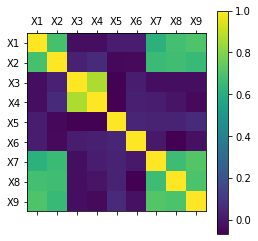

In [111]:
# correlation map

plt.matshow(Ex2.corr())
plt.xticks(range(len(Ex2.columns)), Ex2.columns)
plt.yticks(range(len(Ex2.columns)), Ex2.columns)
plt.colorbar()
plt.show()

## Random Forest Proximities <a name="prox"></a> 

In this Section, proximity and dissimilarity matrices for Uniform and Non-Uniform Random Forests are computed and visualized with the help of the Multidimensional Scaling (MDS) algorithm. Points are colored according to their true cluster affiliation. Also, the Variable Importance Measure (VIM) is computed during the construction of Random Forests and plotted below.  

In [0]:
data = add_synthetic(Ex2)
X_train = transform_dataset(data)
X_apply = transform_dataset(Ex2)

### Uniform

In [0]:
uniform_proximity = get_proximity_matrix(X_train,X_apply,100,3000,2,3, 
                              weights = None
                              ,oob = False)

In [0]:
uniform_dissimilarity = 1 - uniform_proximity[0]

Text(0.5, 1.0, 'Uniform RF dissimilarity')

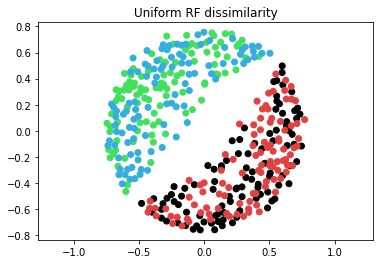

In [115]:
out = model.fit_transform(uniform_dissimilarity)
plt.scatter(out[:, 0], out[:, 1], c = colors,alpha=1)
plt.axis('equal');
plt.title('Uniform RF dissimilarity')


As can be observed, the RF dissimilarity easily finds the distinction between points from different pairs of clusters, namely (1,2) and (3,4). Red and black points form a definite cloud of points, while green and blue points form another specific cloud. However, the uniform procedure has difficulties with revealing the division inside the respective pairs of clusters, which would potentially lead to poor clustering results, since there are four true clusters.

#### Variable importance measure chart 

Text(0.5, 1.0, 'VIMs plotted for Uniform RF')

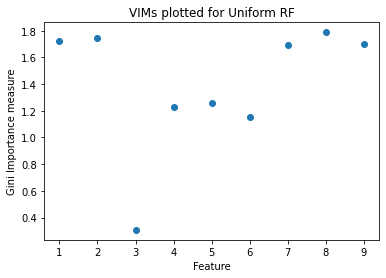

In [116]:

plt.scatter(range(1,len(uniform_proximity[1])+1),uniform_proximity[1])
plt.xticks(range(1,len(uniform_proximity[1])+1))
plt.xlabel('Feature')
plt.ylabel('Gini Importance measure')
plt.title('VIMs plotted for Uniform RF')

### Non-Uniform

In [0]:
non_uniform_proximity = get_proximity_matrix(X_train,X_apply,100,3000,2,3, 
                              weights = [0.05,0.05,0.325,0.325,0.05,0.05,0.05,0.05,0.05]                      
                              ,oob = False)
non_uniform_dissimilarity = 1 - non_uniform_proximity[0]

Text(0.5, 1.0, 'Non-Uniform RF dissimilarity')

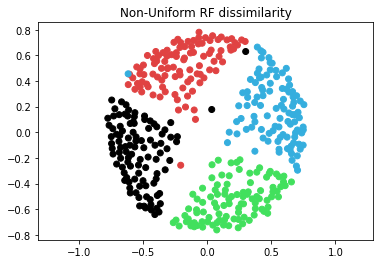

In [118]:
out_1 = model.fit_transform(non_uniform_dissimilarity)
plt.scatter(out_1[:, 0], out_1[:, 1], c = colors,alpha=1)
plt.axis('equal');
plt.title('Non-Uniform RF dissimilarity')



We can see that the NURF dissimilarities have yielded more distinct separation of points than the RF procedure on the MDS plot, which can potentially lead to a better quality of clustering.    


#### Variable importance measure chart 

Text(0.5, 1.0, 'VIMs plotted for Non-Uniform RF')

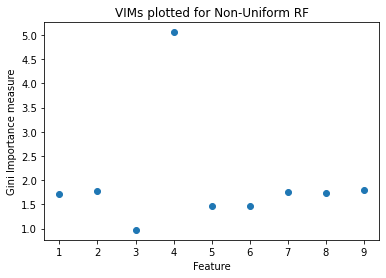

In [119]:

plt.scatter(range(1,len(non_uniform_proximity[1])+1),non_uniform_proximity[1])
plt.xticks(range(1,len(non_uniform_proximity[1])+1))
plt.xlabel('Feature')
plt.ylabel('Gini Importance measure')
plt.title('VIMs plotted for Non-Uniform RF')

## Clustering <a name="clustering"></a> 

In this section, the proximity/dissimilarity measures produced by uniform and non-uniform Random Forests are processed with clustering algorithms in order to finally perform partitioning.
The results are visualized on MDS plots, where the markers denote the cluster assignment of the respective algorithm, the colors denote the true cluster affiliation. The quality of partitioning is evaluated with ARI. 


### Spectral Clustering

#### Uniform

In [0]:
spectral = SpectralClustering(n_clusters = 4,affinity = 'precomputed', n_init=20)
spectral_clusters = spectral.fit_predict(uniform_proximity[0])

In [121]:
adjusted_rand_score(Ex2_clust,spectral_clusters)

0.3911892070601223

Text(0.5, 1.0, 'SC with Uniform RF, ARI = 0.39')

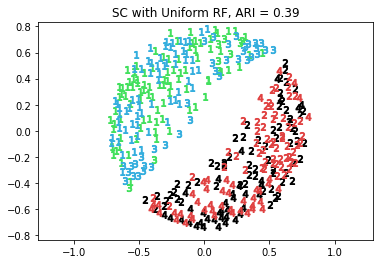

In [122]:

#plt.figure(figsize=(5,5))
for i in range(len(spectral_clusters)):
    if spectral_clusters[i] == 0:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '1', size=1000), alpha=1)
    if spectral_clusters[i] == 1:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '2', size=1000), alpha=1)
    if spectral_clusters[i] == 2:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '3', size=1000), alpha=1)
    if spectral_clusters[i] == 3:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '4', size=1000), alpha=1)
plt.axis('equal');
plt.title('SC with Uniform RF, ARI = 0.39')

#### Non-Uniform

In [0]:
nonu_spectral_clusters = spectral.fit_predict(non_uniform_proximity[0])

In [124]:
adjusted_rand_score(Ex2_clust,nonu_spectral_clusters)

1.0

Text(0.5, 1.0, 'SC with Non-Uniform RF, ARI = 1')

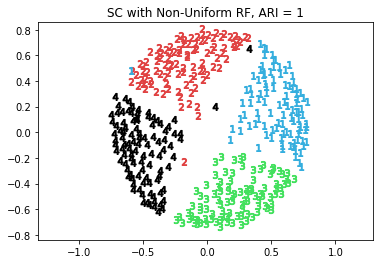

In [125]:

#plt.figure(figsize=(5,5))
for i in range(len(nonu_spectral_clusters)):
    if nonu_spectral_clusters[i] == 0:
        plt.scatter(out_1[i,0], out_1[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '1', size=1000), alpha=1)
    if nonu_spectral_clusters[i] == 1:
        plt.scatter(out_1[i,0], out_1[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '2', size=1000), alpha=1)
    if nonu_spectral_clusters[i] == 2:
        plt.scatter(out_1[i,0], out_1[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '3', size=1000), alpha=1)
    if nonu_spectral_clusters[i] == 3:
        plt.scatter(out_1[i,0], out_1[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '4', size=1000), alpha=1)
plt.axis('equal');
plt.title('SC with Non-Uniform RF, ARI = 1')

### K-medoids Clustering 

### Uniform

In [0]:
PAM_clusters = kMedoids(uniform_dissimilarity,k=4)

In [0]:
# transforming the output for the quality assessment and visualization

cluster_1 = list()
cluster_2 = list()
cluster_3 = list()
cluster_4 = list()

for i in range(len(PAM_clusters[1][0])):
    cluster_1.append(1)
    
for i in range(len(PAM_clusters[1][1])):
    cluster_2.append(2)

for i in range(len(PAM_clusters[1][2])):
    cluster_3.append(3)
    
for i in range(len(PAM_clusters[1][3])):
    cluster_4.append(4)
    
    

clust_1_df = pd.DataFrame(cluster_1,index=PAM_clusters[1][0])
clust_2_df = pd.DataFrame(cluster_2,index=PAM_clusters[1][1])
clust_3_df = pd.DataFrame(cluster_3,index=PAM_clusters[1][2])
clust_4_df = pd.DataFrame(cluster_4,index=PAM_clusters[1][3])

PAM_clusters = pd.concat([clust_1_df,clust_2_df,clust_3_df,clust_4_df
                            ])
PAM_clusters.columns = ['cluster']
PAM_clusters.sort_index(inplace=True)


In [128]:
adjusted_rand_score(Ex2_clust,PAM_clusters['cluster'])

0.42230500837471463

In [0]:
PAM_clusters_a = np.asarray(list(PAM_clusters['cluster']))

Text(0.5, 1.0, 'PAM with Uniform RF, ARI = 0.42')

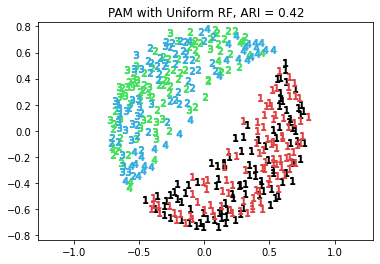

In [130]:
#out

#plt.figure(figsize=(5,5))
for i in range(len(PAM_clusters_a)):
    if PAM_clusters_a[i] == 1:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '1', size=1000), alpha=1)
    if PAM_clusters_a[i] == 2:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '2', size=1000), alpha=1)
    if PAM_clusters_a[i] == 3:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '3', size=1000), alpha=1)
    if PAM_clusters_a[i] == 4:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '4', size=1000), alpha=1)
plt.axis('equal');
plt.title('PAM with Uniform RF, ARI = 0.42')

### Non-Uniform 

In [0]:
nonu_PAM_clusters = kMedoids(non_uniform_dissimilarity,k=4)

In [0]:
# transforming the output for the quality assessment and visualization

cluster_1 = list()
cluster_2 = list()
cluster_3 = list()
cluster_4 = list()

for i in range(len(nonu_PAM_clusters[1][0])):
    cluster_1.append(1)
    
for i in range(len(nonu_PAM_clusters[1][1])):
    cluster_2.append(2)

for i in range(len(nonu_PAM_clusters[1][2])):
    cluster_3.append(3)
    
for i in range(len(nonu_PAM_clusters[1][3])):
    cluster_4.append(4)
    
    

clust_1_df = pd.DataFrame(cluster_1,index=nonu_PAM_clusters[1][0])
clust_2_df = pd.DataFrame(cluster_2,index=nonu_PAM_clusters[1][1])
clust_3_df = pd.DataFrame(cluster_3,index=nonu_PAM_clusters[1][2])
clust_4_df = pd.DataFrame(cluster_4,index=nonu_PAM_clusters[1][3])

nonu_PAM_clusters = pd.concat([clust_1_df,clust_2_df,clust_3_df,clust_4_df
                            ])
nonu_PAM_clusters.columns = ['cluster']
nonu_PAM_clusters.sort_index(inplace=True)
nonu_PAM_clusters_a = np.asarray(list(nonu_PAM_clusters['cluster']))


In [133]:
adjusted_rand_score(Ex2_clust,nonu_PAM_clusters['cluster'])

0.9410697798539766

Text(0.5, 1.0, 'PAM with Non-Uniform RF, ARI = 0.94')

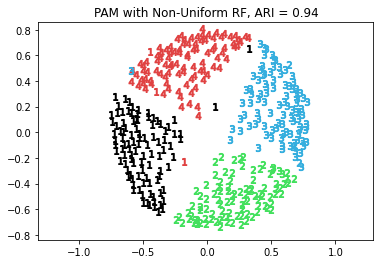

In [134]:
#out

#plt.figure(figsize=(5,5))
for i in range(len(nonu_PAM_clusters_a)):
    if nonu_PAM_clusters_a[i] == 1:
        plt.scatter(out_1[i,0], out_1[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '1', size=1000), alpha=1)
    if nonu_PAM_clusters_a[i] == 2:
        plt.scatter(out_1[i,0], out_1[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '2', size=1000), alpha=1)
    if nonu_PAM_clusters_a[i] == 3:
        plt.scatter(out_1[i,0], out_1[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '3', size=1000), alpha=1)
    if nonu_PAM_clusters_a[i] == 4:
        plt.scatter(out_1[i,0], out_1[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '4', size=1000), alpha=1)
plt.axis('equal');
plt.title('PAM with Non-Uniform RF, ARI = 0.94')

## Conclusion  <a name="conclusion"></a>

As we can see, the NUFR procedure allows to improve the quality of clustering for the Ex2 dataset. The ARI for the NURF procedure paired with Spectral Clustering is 1, compared with 0.39 for the RF procedure with Spectral Clustering, indicating that the quality of clustering is better with the NURF procedure. The same result holds for K-medoids clustering procedure, where the NURF allows to increase the ARI from 0.42 (uniform) to 0.94.  

## Links and References

[1] A full text of the master thesis: <a name="link1"></a>

https://drive.google.com/file/d/1Gy1LzrYAzq4N1ugnnYegNYHeTBmzK0jd/view?usp=sharing

[2] <a name="link2"></a> Bauckhage, C., 2015, "NumPy / SciPy Recipes for Data Science: k-Medoids Clustering,"
doi:10.13140/2.1.4453.2009.
https://www.researchgate.net/publication/272351873_NumPy_SciPy_Recipes_for_Data_Science_k-Medoids_Clustering



[3] <a name="link3"></a> Random Forest from scratch: 
https://machinelearningmastery.com/implement-random-forest-scratch-python/

